# アミノ酸配列のグラフ表示画像のVision Transformerによるタンパク質ファミリー分類（5分割交差検証）
- グラデーション適用
- クラスごとに分ける `StratifiedKFold` を採用
- ベースモデル：`google/vit-base-patch16-224-in21k`
- ハイパーパラメータ
    - バッチサイズ：$16$
    - エポック数：$20$
    - 学習率：$5 \times 10^{-5}$
    - ドロップアウト率：$0.1$

## 1. ライブラリのインポート

In [1]:
from torch.utils.data import Dataset, Subset
from PIL import Image
import os
import pandas as pd
import numpy as np

from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from transformers import ViTImageProcessorFast, ViTForImageClassification, TrainingArguments, Trainer, ViTConfig
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import evaluate

label2id = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
id2label = {v: k for k, v in label2id.items()}

MODEL_NAME = "google/vit-base-patch16-224-in21k"
BATCH_SIZE = 16
EPOCHS = 20
LR = 5e-5
DROPOUT = 0.1
# WEIGHT_DECAY = 1e-4

## 1. 画像とラベルの対応を取る `Dataset` を作成

In [2]:
class GPCRImageDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path, header=None, names=["num", "label", "accession"])
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, f"{row['num']}.png")
        image = Image.open(img_path).convert("RGB")
        label = label2id[row["label"]]

        if self.transform:
            image = self.transform(image)
        return {"pixel_values": image, "label": label}

## 2. 画像前処理（ViT用）

In [3]:
processor = ViTImageProcessorFast.from_pretrained(MODEL_NAME)
transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=processor.image_mean, std=processor.image_std)
])

## 3. `Trainer` を使って学習

In [4]:
accuracy = evaluate.load("accuracy")
dataset = GPCRImageDataset("../gpcr_labels.csv", "../graphs/gradation", transform=transform)

# StratifiedKFoldはラベル情報を使う
labels = dataset.data["label"].values
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

[Fold 1 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_50780\3184980878.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.171936,0.955311,0.541949,0.547866,0.544827
2,0.311500,0.138270,0.964378,0.567133,0.552869,0.559614
3,0.126300,0.177003,0.950130,0.735652,0.602883,0.623879
4,0.064200,0.139163,0.966321,0.791540,0.888993,0.826289
5,0.064200,0.158322,0.968264,0.782036,0.748519,0.762780
6,0.037900,0.172758,0.968264,0.782050,0.747195,0.762464
7,0.029600,0.167984,0.968912,0.773723,0.760432,0.766550
8,0.022000,0.190849,0.965026,0.776185,0.757268,0.765207
9,0.022000,0.207058,0.958549,0.758283,0.758101,0.758061
10,0.021600,0.175860,0.969560,0.765943,0.763669,0.764773


Accuracy: 0.9702 | Precision: 0.7798 | Recall: 0.7561 | F1: 0.7669
              precision    recall  f1-score      support
A              0.978565  0.989632  0.984067  1061.000000
B              0.974359  0.835165  0.899408    91.000000
C              0.946015  0.955844  0.950904   385.000000
D              0.000000  0.000000  0.000000     3.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.970207  0.970207  0.970207     0.970207
macro avg      0.779788  0.756128  0.766876  1544.000000
weighted avg   0.968355  0.970207  0.968938  1544.000000


E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


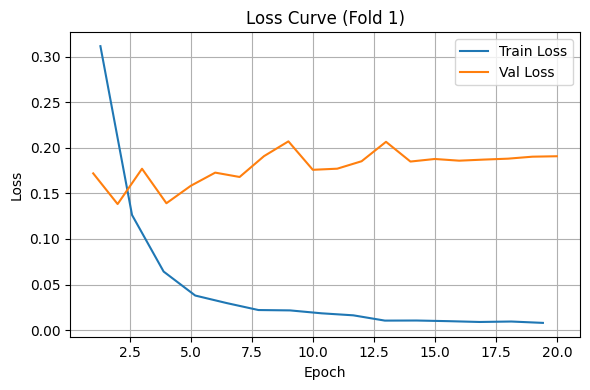

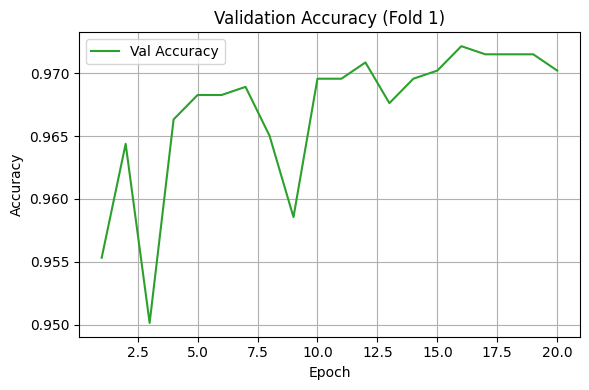

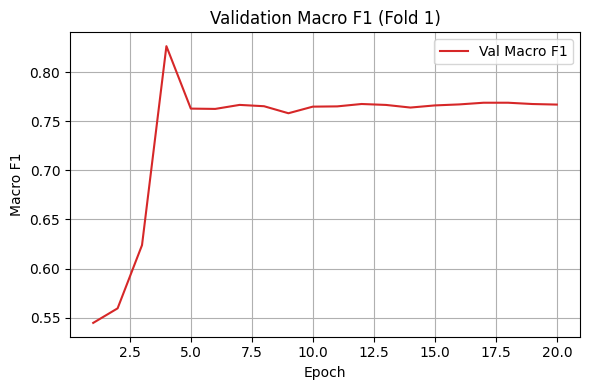

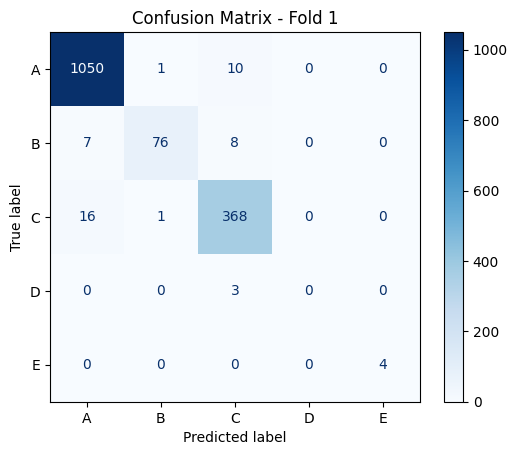

[Fold 2 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_50780\3184980878.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.240052,0.939728,0.568540,0.503962,0.528612
2,0.311100,0.132079,0.962411,0.565304,0.551451,0.558060
3,0.109800,0.153596,0.960467,0.722529,0.733062,0.721791
4,0.061600,0.141831,0.961763,0.665974,0.756798,0.700971
5,0.061600,0.154666,0.968892,0.725056,0.740071,0.725944
6,0.039100,0.259101,0.944264,0.872163,0.874273,0.871327
7,0.032700,0.176920,0.965003,0.770667,0.675870,0.713967
8,0.021100,0.195411,0.953986,0.781170,0.806561,0.785953
9,0.021100,0.173495,0.968892,0.903326,0.881877,0.891288
10,0.023300,0.177303,0.965651,0.848902,0.879890,0.859423


Accuracy: 0.9682 | Precision: 0.8975 | Recall: 0.8823 | F1: 0.8891
              precision    recall  f1-score      support
A              0.986742  0.982092  0.984412  1061.000000
B              0.898734  0.788889  0.840237    90.000000
C              0.935323  0.974093  0.954315   386.000000
D              0.666667  0.666667  0.666667     3.000000
E              1.000000  1.000000  1.000000     3.000000
accuracy       0.968244  0.968244  0.968244     0.968244
macro avg      0.897493  0.882348  0.889126  1543.000000
weighted avg   0.968149  0.968244  0.967886  1543.000000


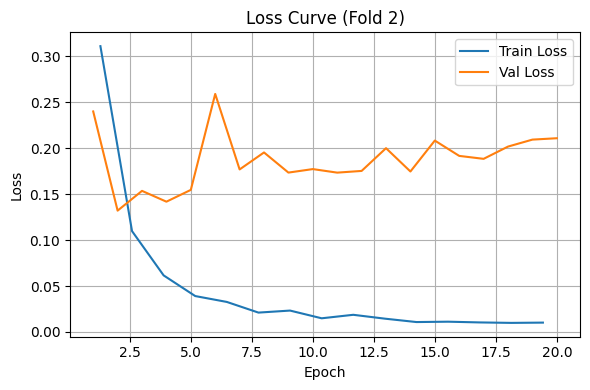

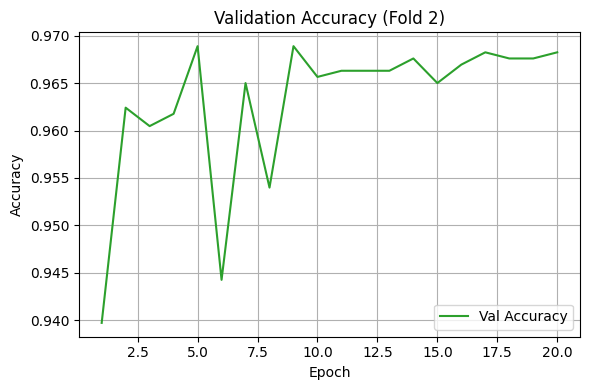

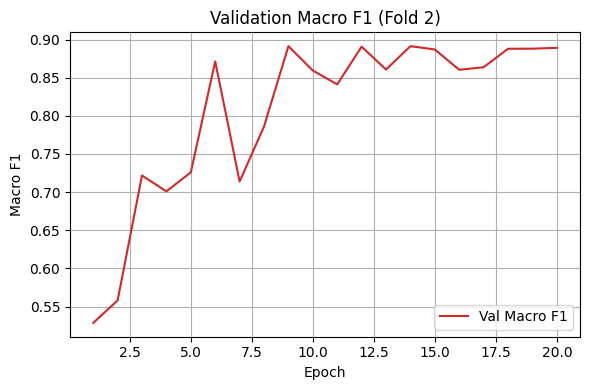

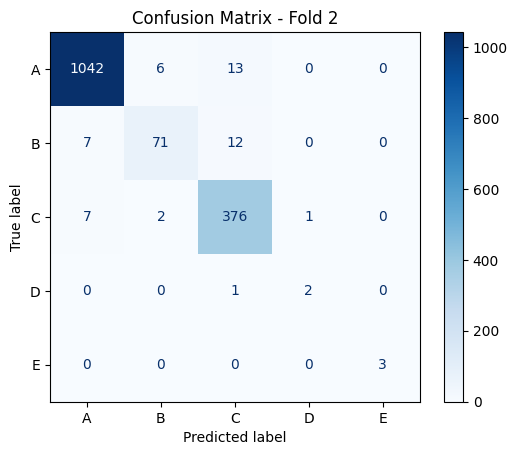

[Fold 3 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_50780\3184980878.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.188437,0.944913,0.540952,0.549189,0.544151
2,0.314200,0.146703,0.963059,0.752789,0.640221,0.662578
3,0.112600,0.145567,0.961763,0.751417,0.702994,0.719962
4,0.064200,0.157670,0.964355,0.760747,0.700390,0.723854
5,0.064200,0.142126,0.965651,0.771557,0.697408,0.727664
6,0.043800,0.177993,0.960467,0.756432,0.699652,0.720867
7,0.025200,0.184747,0.960467,0.676221,0.705285,0.689200
8,0.020300,0.180231,0.966948,0.774260,0.764263,0.769043
9,0.020300,0.191307,0.967596,0.768959,0.703310,0.729447
10,0.016600,0.193145,0.967596,0.768877,0.702948,0.729079


Accuracy: 0.9702 | Precision: 0.7714 | Recall: 0.7692 | F1: 0.7703
              precision    recall  f1-score      support
A              0.979381  0.985849  0.982605  1060.000000
B              0.922222  0.912088  0.917127    91.000000
C              0.955614  0.948187  0.951886   386.000000
D              0.000000  0.000000  0.000000     3.000000
E              1.000000  1.000000  1.000000     3.000000
accuracy       0.970188  0.970188  0.970188     0.970188
macro avg      0.771443  0.769225  0.770323  1543.000000
weighted avg   0.968201  0.970188  0.969182  1543.000000


E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


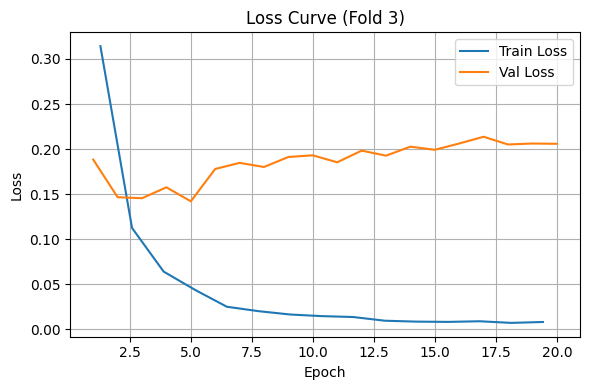

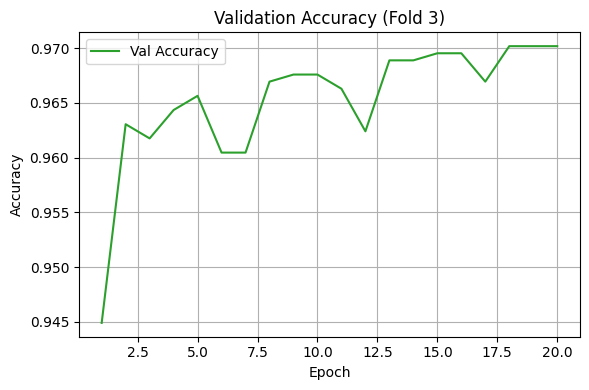

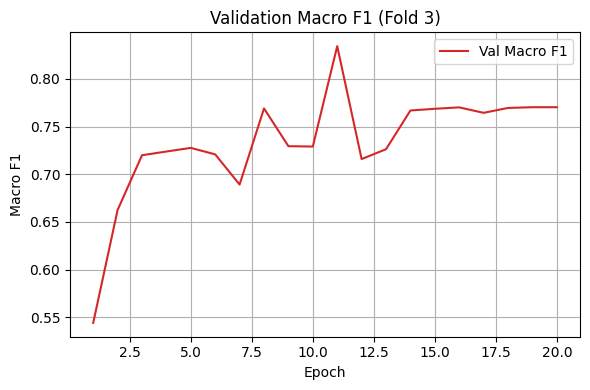

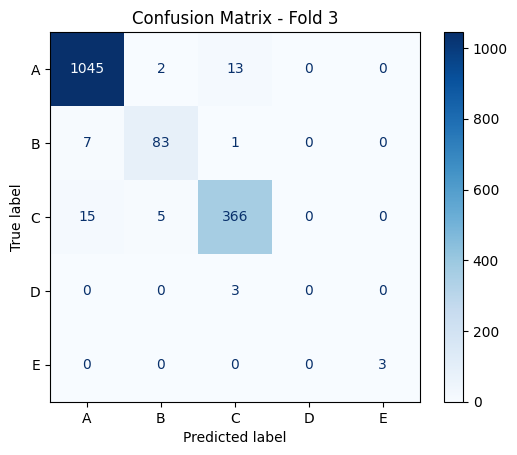

[Fold 4 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_50780\3184980878.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.209327,0.948153,0.544761,0.540222,0.541393
2,0.310300,0.227943,0.933895,0.751063,0.572801,0.615369
3,0.121300,0.146671,0.959819,0.752830,0.645580,0.681885
4,0.065600,0.162065,0.960467,0.753959,0.757905,0.755612
5,0.065600,0.161006,0.962411,0.794026,0.846460,0.813113
6,0.032300,0.214929,0.960467,0.875457,0.966784,0.913584
7,0.026900,0.173222,0.964355,0.763197,0.754954,0.758935
8,0.019400,0.182794,0.963707,0.765542,0.756083,0.760500
9,0.019400,0.165636,0.968892,0.772789,0.755913,0.763741
10,0.021500,0.155033,0.971484,0.860434,0.871531,0.865796


Accuracy: 0.9689 | Precision: 0.7679 | Recall: 0.7633 | F1: 0.7654
              precision    recall  f1-score      support
A              0.985755  0.979245  0.982489  1060.000000
B              0.918605  0.868132  0.892655    91.000000
C              0.935000  0.968912  0.951654   386.000000
D              0.000000  0.000000  0.000000     2.000000
E              1.000000  1.000000  1.000000     4.000000
accuracy       0.968892  0.968892  0.968892     0.968892
macro avg      0.767872  0.763258  0.765360  1543.000000
weighted avg   0.967857  0.968892  0.968249  1543.000000


E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\GR2025\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


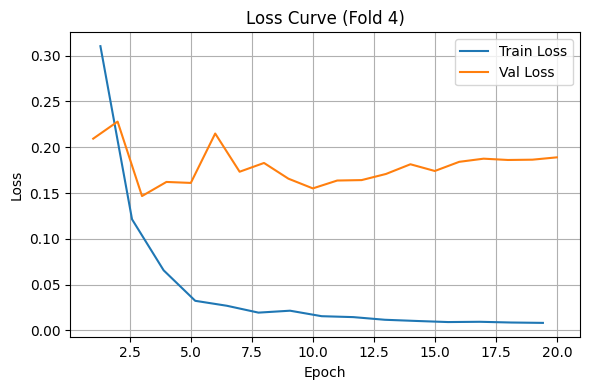

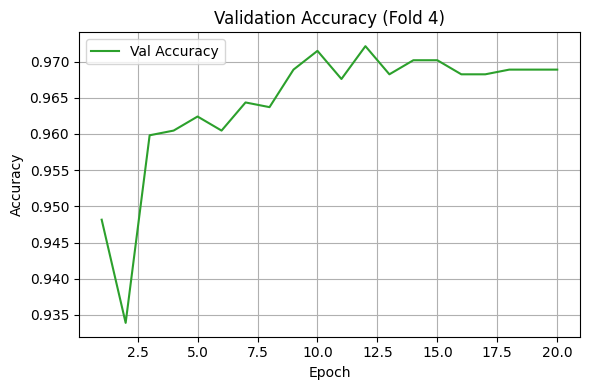

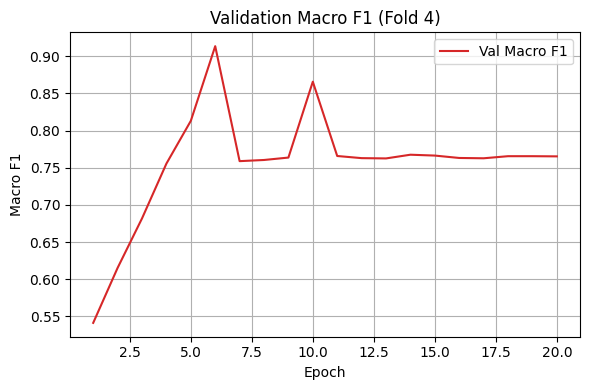

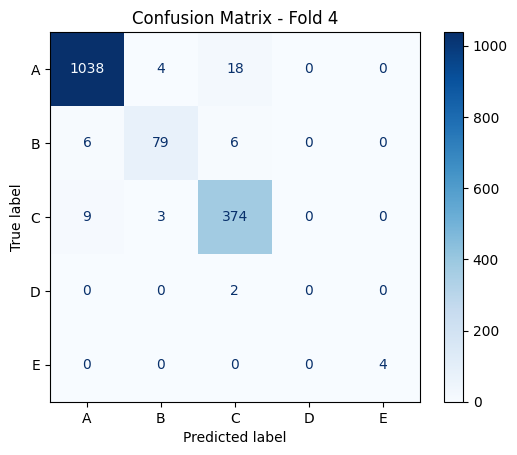

[Fold 5 / 5]


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ArchWizard7\AppData\Local\Temp\ipykernel_50780\3184980878.py:55: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.227578,0.938432,0.554433,0.506099,0.526430
2,0.306900,0.137005,0.961763,0.668448,0.598770,0.624733
3,0.113700,0.142557,0.963059,0.763535,0.644217,0.686164
4,0.066500,0.141613,0.967596,0.770179,0.754185,0.761574
5,0.066500,0.191639,0.963059,0.976514,0.843024,0.891420
6,0.036300,0.135262,0.968892,0.966825,0.860401,0.896785
7,0.025300,0.181060,0.965651,0.874353,0.858172,0.865870
8,0.020100,0.180797,0.964355,0.824364,0.856115,0.837924
9,0.020100,0.175828,0.964355,0.820526,0.846367,0.823632
10,0.021300,0.203040,0.958522,0.795304,0.868810,0.827693


Accuracy: 0.9669 | Precision: 0.8276 | Recall: 0.8602 | F1: 0.8416
              precision    recall  f1-score      support
A              0.979304  0.982075  0.980688  1060.000000
B              0.908046  0.868132  0.887640    91.000000
C              0.950777  0.950777  0.950777   386.000000
D              0.500000  0.500000  0.500000     2.000000
E              0.800000  1.000000  0.888889     4.000000
accuracy       0.966948  0.966948  0.966948     0.966948
macro avg      0.827625  0.860197  0.841599  1543.000000
weighted avg   0.966879  0.966948  0.966857  1543.000000


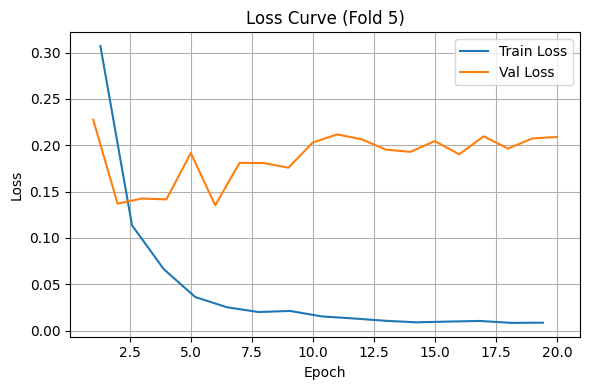

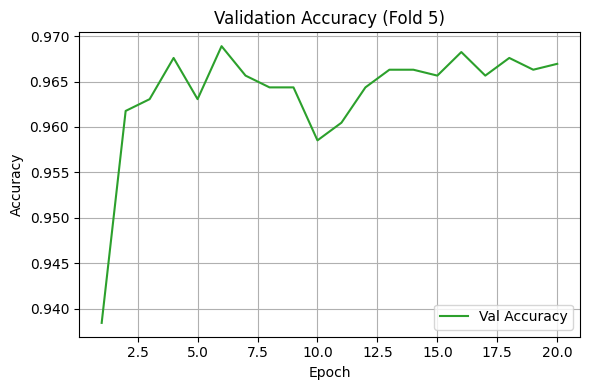

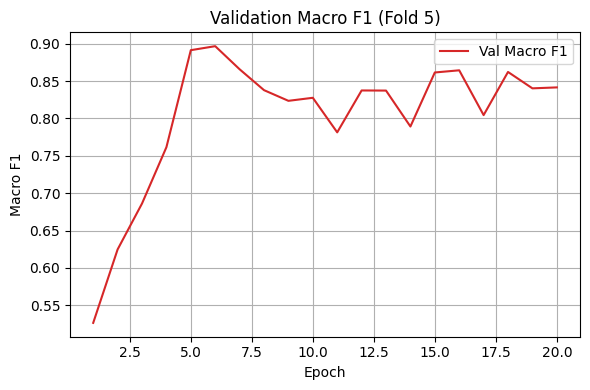

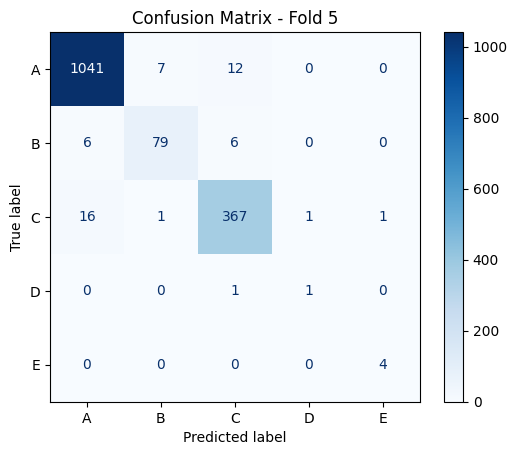

In [5]:
all_accs, all_pres, all_recs, all_f1s = [], [], [], []
all_class_f1s, all_conf_matrices = [], []
all_val_losses, all_val_accs, all_val_f1s = [], [], []

for fold, (train_idx, val_idx) in enumerate(kfold.split(np.zeros(len(labels)), labels)):
    print(f"\033[34m[Fold {fold+1} / 5]\033[0m")

    # Subset 作成
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)

    config = ViTConfig(
        hidden_dropout_prob=DROPOUT,
        attention_probs_dropout_prob=DROPOUT
    )

    # ======================
    # 4. モデル初期化
    # ======================
    model = ViTForImageClassification.from_pretrained(
        MODEL_NAME,
        num_labels=5,
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=f"../models/amino-classification-transformer-vit-google-stratified-kfold/batch-{BATCH_SIZE}-epoch-{EPOCHS}-lr-{LR}-dropout-{DROPOUT}/{fold+1}",
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        eval_strategy="epoch",
        save_strategy="no",
        num_train_epochs=EPOCHS,
        logging_dir="./logs",
        report_to="none",
        learning_rate=LR,
        load_best_model_at_end=False
    )

    # ======================
    # 5. 評価指標
    # ======================
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        acc = accuracy.compute(predictions=preds, references=labels)["accuracy"]
        f1 = f1_score(labels, preds, average="macro")
        pre = precision_score(labels, preds, average="macro", zero_division=0)
        rec = recall_score(labels, preds, average="macro", zero_division=0)
        return {"accuracy": acc, "precision": pre, "recall": rec, "f1": f1}

    # ======================
    # 6. Trainer実行
    # ======================
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=processor,
        compute_metrics=compute_metrics
    )

    trainer.train()

    # ==== ログから学習曲線抽出 ====
    log_history = pd.DataFrame(trainer.state.log_history)
    log_history = log_history.dropna(subset=["epoch"])
    train_loss = log_history[log_history["loss"].notna()][["epoch", "loss"]]
    eval_loss = log_history[log_history["eval_loss"].notna()][["epoch", "eval_loss", "eval_accuracy", "eval_f1"]]

    all_val_losses.append(eval_loss["eval_loss"].values)
    all_val_accs.append(eval_loss["eval_accuracy"].values)
    all_val_f1s.append(eval_loss["eval_f1"].values)

    # ======================
    # 7. 推論と評価
    # ======================
    preds = trainer.predict(val_dataset)
    y_true = preds.label_ids
    y_pred = np.argmax(preds.predictions, axis=1)

    acc = accuracy.compute(predictions=y_pred, references=y_true)["accuracy"]
    pre = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_true, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=list(label2id.values()))

    report = classification_report(y_true, y_pred, target_names=list(label2id.keys()), output_dict=True)
    class_f1 = [report[c]["f1-score"] for c in list(label2id.keys())]

    # ==== 保存 ====
    all_accs.append(acc)
    all_pres.append(pre)
    all_recs.append(rec)
    all_f1s.append(f1)
    all_class_f1s.append(class_f1)
    all_conf_matrices.append(cm)

    # ==== 表示 ====
    print(f"\033[91mAccuracy: {acc:.4f}\033[0m | "
          f"\033[92mPrecision: {pre:.4f}\033[0m | "
          f"\033[93mRecall: {rec:.4f}\033[0m | "
          f"\033[94mF1: {f1:.4f}\033[0m")
    print(pd.DataFrame(report).T)

    # ==== foldごとの学習曲線を可視化 ====
    # --- Loss 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(train_loss["epoch"], train_loss["loss"], label="Train Loss", color="C0")
    plt.plot(eval_loss["epoch"], eval_loss["eval_loss"], label="Val Loss", color="C1")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Loss Curve (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Accuracy 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_accuracy"], label="Val Accuracy", color="C2")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Validation Accuracy (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Macro F1 曲線 ---
    plt.figure(figsize=(6, 4))
    plt.plot(eval_loss["epoch"], eval_loss["eval_f1"], label="Val Macro F1", color="C3")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title(f"Validation Macro F1 (Fold {fold+1})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 混同行列を可視化
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label2id.keys()))
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - Fold {fold+1}")
    plt.show()

## 4. 平均可視化

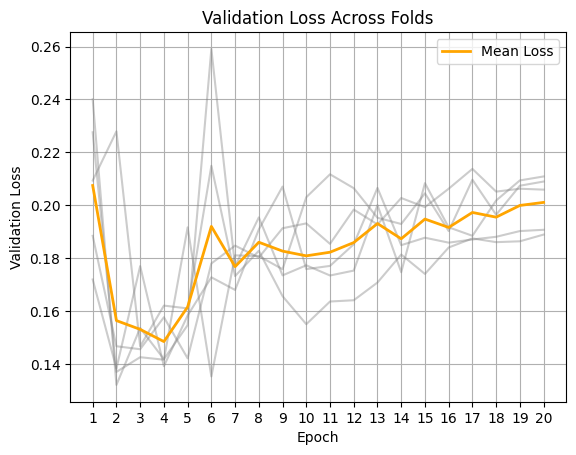

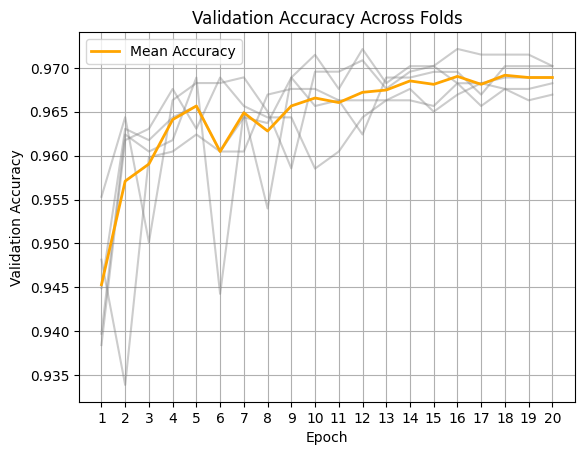

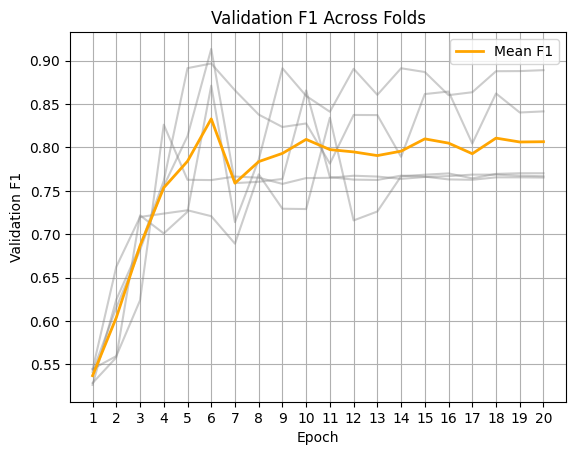

In [6]:
epochs = np.arange(1, EPOCHS + 1)

def interp_to_epochs(arr):
    arr = np.asarray(arr)
    orig_x = np.arange(1, len(arr) + 1)

    if len(arr) == 1:
        return np.full_like(epochs, arr[0], dtype=float)

    return np.interp(epochs, orig_x, arr)

def plot_mean_curves(all_vals, y_label, title, metric_name):
    interp_vals = []

    for v in all_vals:
        v_interp = interp_to_epochs(v)
        interp_vals.append(v_interp)
        plt.plot(epochs, v_interp, color="gray", alpha=0.4)

    interp_vals = np.vstack(interp_vals)
    mean_vals = interp_vals.mean(axis=0)

    plt.plot(epochs, mean_vals, color="orange", linewidth=2, label=f"Mean {metric_name}")
    plt.xlabel("Epoch"); plt.ylabel(y_label); plt.title(title)
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)
    plt.show()

plot_mean_curves(all_val_losses, "Validation Loss", "Validation Loss Across Folds", "Loss")
plot_mean_curves(all_val_accs, "Validation Accuracy", "Validation Accuracy Across Folds", "Accuracy")
plot_mean_curves(all_val_f1s, "Validation F1", "Validation F1 Across Folds", "F1")

## 5. 総合評価


===== Average Across 5 Folds =====
Accuracy : 0.9689
Precision: 0.8088
Recall   : 0.8062
F1       : 0.8067

Per-Class F1 (Macro Average):
  A: 0.9829
  B: 0.8874
  C: 0.9519
  D: 0.2333
  E: 0.9778


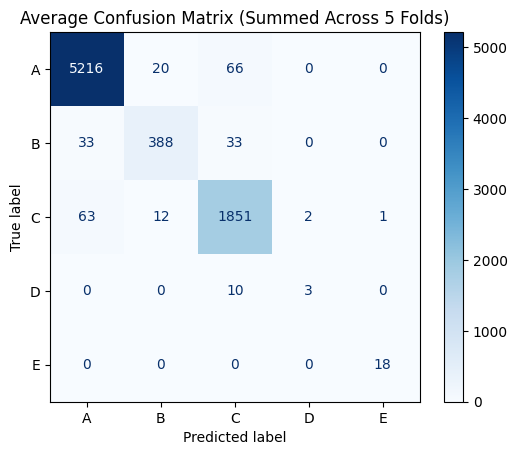

In [7]:
mean_acc = np.mean(all_accs)
mean_pre = np.mean(all_pres)
mean_rec = np.mean(all_recs)
mean_f1 = np.mean(all_f1s)
mean_class_f1 = np.mean(np.array(all_class_f1s), axis=0)

print("\n\033[36m===== Average Across 5 Folds =====\033[0m")
print(f"Accuracy : {mean_acc:.4f}")
print(f"Precision: {mean_pre:.4f}")
print(f"Recall   : {mean_rec:.4f}")
print(f"F1       : {mean_f1:.4f}\n")

print("Per-Class F1 (Macro Average):")
for cls, score in zip(label2id.keys(), mean_class_f1):
    print(f"  {cls}: {score:.4f}")

# ==== 混同行列平均表示 ====
mean_cm = np.sum(all_conf_matrices, axis=0)
disp = ConfusionMatrixDisplay(confusion_matrix=mean_cm, display_labels=list(label2id.keys()))
disp.plot(cmap="Blues")
plt.title("Average Confusion Matrix (Summed Across 5 Folds)")
plt.show()